# Import

In [288]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

plt.rcParams['figure.figsize'] = (14,6)

# Read Data

In [137]:
df = pd.read_csv("data/TG_STAID002759.txt", skiprows=19, index_col=1, parse_dates=True)

In [138]:
df.head()

,SOUID,TG,Q_TG
DATE,,,
1876-01-01,127488,22,0
1876-01-02,127488,25,0
1876-01-03,127488,3,0
1876-01-04,127488,-58,0
1876-01-05,127488,-98,0


In [139]:
df.isna().sum()

 SOUID    0
   TG     0
 Q_TG     0
dtype: int64

# Clean Data

### Rename columns

In [140]:
df.columns

Index([' SOUID', '   TG', ' Q_TG'], dtype='object')

In [141]:
df.columns = ['SOUID', 'TG', 'Q_TG']

### Missing Values

In [142]:
print(df[df['Q_TG'] == 9])

             SOUID    TG  Q_TG
    DATE                      
1945-04-25  127488 -9999     9
1945-04-26  127488 -9999     9
1945-04-27  127488 -9999     9
1945-04-28  127488 -9999     9
1945-04-29  127488 -9999     9
...            ...   ...   ...
1945-11-01  127488 -9999     9
1945-11-02  127488 -9999     9
1945-11-03  127488 -9999     9
1945-11-04  127488 -9999     9
1945-11-05  127488 -9999     9

[195 rows x 3 columns]


#### Remove missing values

In [236]:
df_clean = df[df['Q_TG'] != 9].copy() # Removes missing values

#### Replace missing values with average of daily temperatures of previous and following year

In [260]:
df_clean_2 = df.copy()

In [261]:
missing_values = df[df['Q_TG'] == 9]
missing_values_1y_bf = missing_values.index - pd.DateOffset(years=1)
missing_values_1y_af = missing_values.index + pd.DateOffset(years=1)

In [262]:
temp_replace = (df[missing_values_1y_bf.min():missing_values_1y_bf.max()].reset_index()['TG'] \
+ df[missing_values_1y_af.min():missing_values_1y_af.max()].reset_index()['TG'])/2

In [263]:
temp_replace.index = missing_values.index

In [264]:
df_clean_2.loc[(df['Q_TG'] == 9), 'TG'] = temp_replace

## Train-Test-Split

In [292]:
train = df_clean_2.iloc[:-365]
test = df_clean_2.iloc[-365:]

#### Remove unnessary columns and create new features

In [293]:
def feature_impl(df):
    df['temp'] = df['TG'] / 10
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df = df.drop(['SOUID','Q_TG', 'TG'], axis=1)
    
    return df

In [294]:
train = feature_impl(train)

<ipython-input-293-7a4b7ab6f4bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = df['TG'] / 10
<ipython-input-293-7a4b7ab6f4bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.index.year
<ipython-input-293-7a4b7ab6f4bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [295]:
test = feature_impl(test)

<ipython-input-293-7a4b7ab6f4bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temp'] = df['TG'] / 10
<ipython-input-293-7a4b7ab6f4bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df.index.year
<ipython-input-293-7a4b7ab6f4bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [296]:
X_train = train.drop('temp', axis=1)
y_train = train['temp'] 
X_test = test.drop('temp', axis=1)
y_test = test['temp']

## EDA - Plot data

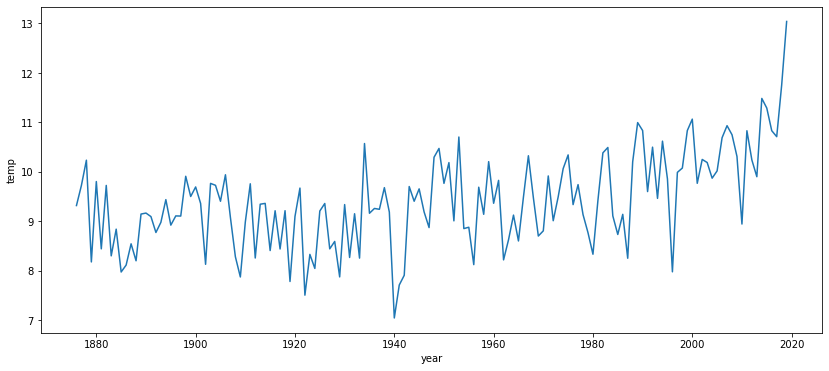

In [297]:
sns.lineplot(x='year', y='temp', data=train.resample('Y').mean())

## Model data

### Linear trend

In [298]:
X_train['timestamp'] = list(range(len(X_train.index)))

In [337]:
X = X_train[['timestamp']]
y = y_train

m_linear = LinearRegression()
m_linear.fit(X,y)

LinearRegression()

In [339]:
train['general_trend'] = m_linear.predict(X)

In [340]:
m_linear.score(X, y)

0.003979963519637364

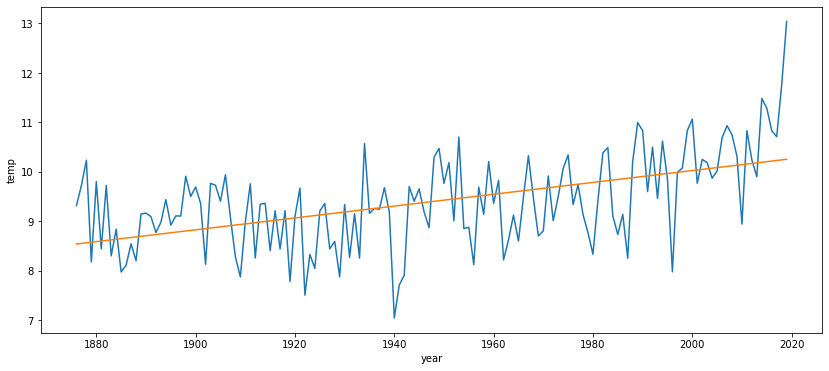

In [302]:
sns.lineplot(x='year', y='temp', data=train.resample('Y').mean())
sns.lineplot(x='year', y='general_trend', data=train.resample('Y').mean())

## Trend with seasonality - Linear Regression

In [335]:
season_dummies = pd.get_dummies(X_train['month'], prefix='month', drop_first=True).set_index(X_train.index)

In [336]:
X_train = X_train.join(season_dummies)

ValueError: columns overlap but no suffix specified: Index(['month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [305]:
X_train.columns

Index(['year', 'month', 'day', 'timestamp', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [341]:
X = X_train.drop(['month', 'year'], axis=1)
y = y_train

m_onehot = LinearRegression()
m_onehot.fit(X,y)

LinearRegression()

In [342]:
train['seasonal_trend'] = m_onehot.predict(X)

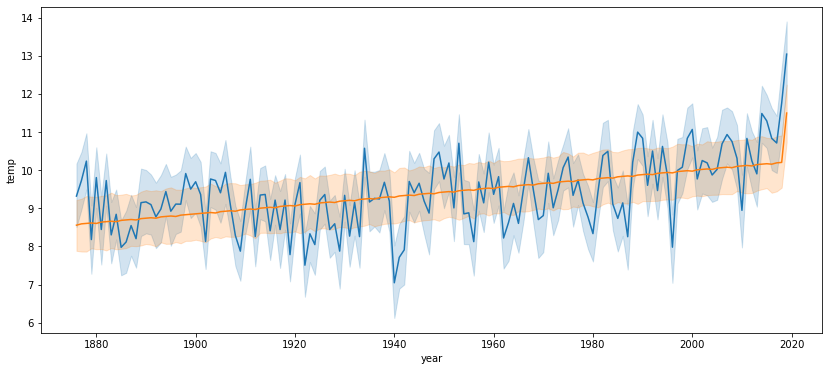

In [343]:
sns.lineplot(x='year', y='temp', data=train)
sns.lineplot(x='year', y='seasonal_trend', data=train)

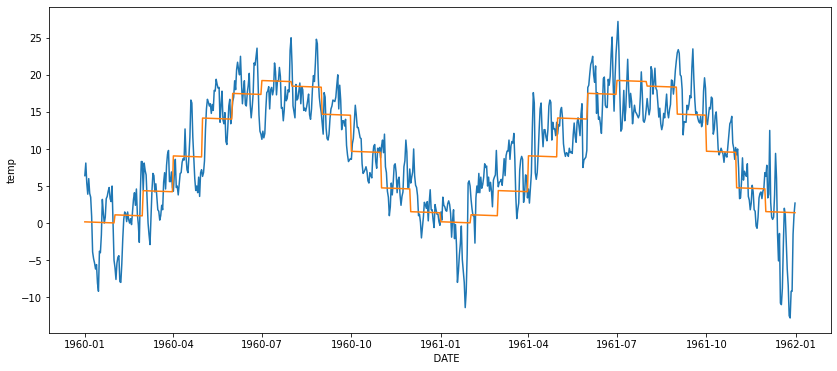

In [344]:
sns.lineplot(x=train['1960':'1961'].index, y='temp', data=train['1960':'1961'])
sns.lineplot(x=train['1960':'1961'].index, y='seasonal_trend', data=train['1960':'1961'])

In [345]:
m_onehot.score(X, y)

0.7517162595455603

## Trend with seasonality - Polynomial Feature

In [394]:
poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = pd.DataFrame(poly.fit_transform(X_train[['month']]), index=X_train.index)

In [395]:
poly_features.head()

,0,1,2,3
DATE,,,,
1876-01-01,1.0,1.0,1.0,1.0
1876-01-02,1.0,1.0,1.0,1.0
1876-01-03,1.0,1.0,1.0,1.0
1876-01-04,1.0,1.0,1.0,1.0
1876-01-05,1.0,1.0,1.0,1.0


In [396]:
poly_features['timestamp'] = X_train['timestamp']

In [397]:
X = poly_features
y = y_train

m_poly = LinearRegression()
m_poly.fit(X,y)

LinearRegression()

In [398]:
train['seasonal_trend_poly'] = m_poly.predict(X)

In [399]:
m_poly.score(X, y)

0.7503035694109832

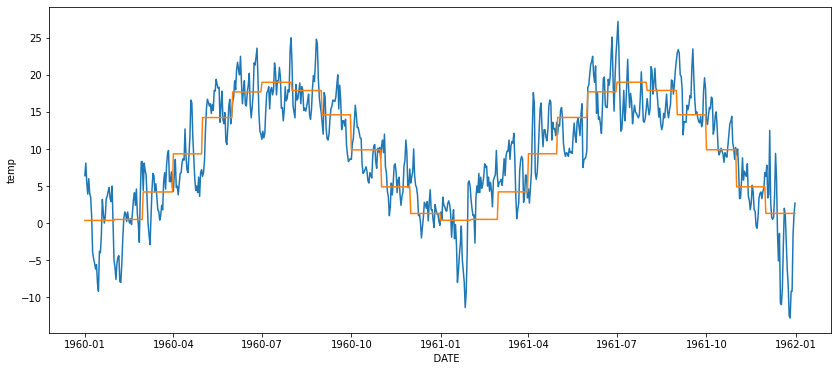

In [400]:
sns.lineplot(x=train['1960':'1961'].index, y='temp', data=train['1960':'1961'])
sns.lineplot(x=train['1960':'1961'].index, y='seasonal_trend_poly', data=train['1960':'1961'])

## Remainder

In [401]:
train['remainder'] = train['temp'] - train['seasonal_trend']

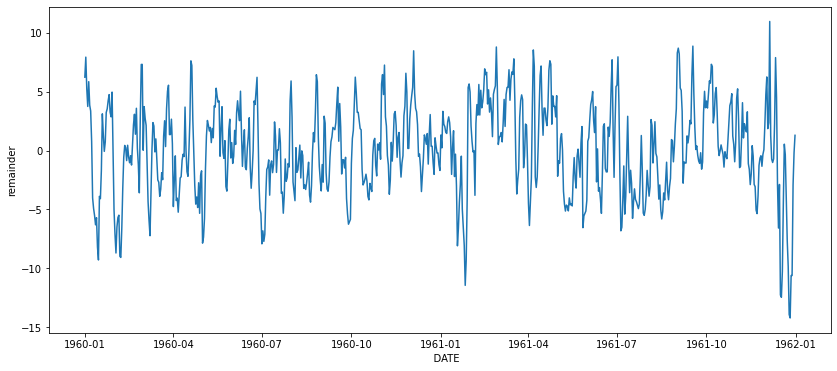

In [403]:
sns.lineplot(x=train['1960':'1961'].index, y='remainder', data=train['1960':'1961'])